In [1]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

%matplotlib inline

Download the datasets

In [2]:
if not os.path.exists('test'):
  !curl -L "https://app.roboflow.com/ds/Sfh5Af5dW4?key=jATmL1hVn2" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
else :
  print("Data Already Downloaded")

Data Already Downloaded


Change dataset to tensor and split data into train & validation dataset

In [3]:
train_dataset = ImageFolder("/content/train", transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                      [0.42045337, 0.27952126, 0.1714828],
                                      [0.28596467, 0.20711626, 0.15339227]
                                    )
                                    ]))
val_dataset = ImageFolder("/content/valid", transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                      [0.41985467, 0.27904496, 0.17095801],
                                      [0.28720343, 0.21039827, 0.15373342]
                                    )
                                    ]))

len(train_dataset), len(val_dataset)

(3130, 834)

Search the mean and std for Normalize the dataset before training to a model

In [4]:
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# def mean_std_for_loader1(loader: DataLoader):
#     mean = torch.zeros(3)
#     std = torch.zeros(3)
#     for X, _ in loader:
#         for d in range(3):
#             mean[d] += X[:, d, :, :].mean()
#             std[d] += X[:, d, :, :].std()
#     mean.div_(len(loader))
#     std.div_(len(loader))
#     return list(mean.numpy()), list(std.numpy())

# means, stds = mean_std_for_loader1(val_loader)
# print(means)
# print(stds)

Create data loaders for training and validation

In [5]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

### Import ResNet-18 architecture for train model

In [6]:
import torch.nn as nn

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Set the output according to the number of existing class
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

### Make helper functions & class for move model & data to the GPU

In [7]:
def get_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [8]:
device = get_device()
device

device(type='cuda')

In [9]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [10]:
model = to_device(model, device)

### Make two functions for eval & train the model

In [11]:
loss_fn = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Evaluation Phase
with torch.inference_mode():
  def evaluate (model, val_loader):
    model.eval()
    running_loss = 0
    running_corrects = 0

    for inputs, labels in val_loader:
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = loss_fn(outputs, labels)
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100
    val_loss.append(epoch_loss)
    val_acc.append(epoch_acc)

    print(f"Val Loss : {epoch_loss:.3f} | Acc : {epoch_acc:.3f}%\n")

# Training Phase
def trainmodel(epochs, lr, model, train_loader, val_loader, optimizer=torch.optim.SGD):
    optimizer = optimizer(model.parameters(), lr)

    for epoch in range(epochs):
      model.train()
      running_loss = 0
      running_corrects = 0

      for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      epoch_loss = running_loss / len(train_dataset)
      epoch_acc = running_corrects / len(train_dataset) * 100
      train_loss.append(epoch_loss)
      train_acc.append(epoch_acc)
      print(f"Epoch [{epoch}] : \nTrain Loss : {epoch_loss:.3f} | Acc : {epoch_acc:.3f}%")
      
      # Validation
      evaluate(model, val_loader)

Running the Train and Evaluation Function

In [12]:
epochs = 60
lr = 0.0004

torch.manual_seed(42)
trainmodel(epochs, lr, model, train_loader, val_loader) 

Epoch [0] : 
Train Loss : 1.140 | Acc : 55.367%
Val Loss : 0.930 | Acc : 68.225%

Epoch [1] : 
Train Loss : 0.875 | Acc : 68.722%
Val Loss : 0.741 | Acc : 76.379%

Epoch [2] : 
Train Loss : 0.729 | Acc : 76.198%
Val Loss : 0.645 | Acc : 78.777%

Epoch [3] : 
Train Loss : 0.650 | Acc : 78.403%
Val Loss : 0.565 | Acc : 81.175%

Epoch [4] : 
Train Loss : 0.576 | Acc : 81.502%
Val Loss : 0.501 | Acc : 84.293%

Epoch [5] : 
Train Loss : 0.522 | Acc : 83.450%
Val Loss : 0.449 | Acc : 86.091%

Epoch [6] : 
Train Loss : 0.469 | Acc : 85.240%
Val Loss : 0.413 | Acc : 87.530%

Epoch [7] : 
Train Loss : 0.430 | Acc : 86.486%
Val Loss : 0.385 | Acc : 86.930%

Epoch [8] : 
Train Loss : 0.397 | Acc : 87.316%
Val Loss : 0.356 | Acc : 88.249%

Epoch [9] : 
Train Loss : 0.371 | Acc : 88.371%
Val Loss : 0.342 | Acc : 88.010%

Epoch [10] : 
Train Loss : 0.358 | Acc : 88.435%
Val Loss : 0.326 | Acc : 88.609%

Epoch [11] : 
Train Loss : 0.344 | Acc : 88.498%
Val Loss : 0.308 | Acc : 88.729%

Epoch [12] : 


### Change the contents list of Loss & Accuracy from tensor to float

In [37]:
def convert_tensor(list_acc):
  result = [tensor.cpu() for tensor in list_acc]
  result = [results.item() for results in list_acc]
  print(result)

  return result

In [45]:
list_trainval = [train_acc, val_acc]

for i in list_trainval:
  # End of looping will save to result (val_acc)
  result = convert_tensor(i)

[55.367408752441406, 68.7220458984375, 76.19808197021484, 78.40255737304688, 81.50159454345703, 83.45047760009766, 85.23961639404297, 86.48562622070312, 87.31629180908203, 88.37060546875, 88.43450927734375, 88.49839782714844, 89.52076721191406, 90.19168853759766, 91.08626556396484, 90.54312896728516, 91.66133880615234, 91.46964263916016, 91.46964263916016, 92.4600601196289, 92.17252349853516, 93.06709289550781, 92.61980438232422, 93.0031967163086, 92.93929290771484, 93.67411804199219, 94.34504699707031, 94.12139892578125, 93.61022186279297, 94.72843170166016, 95.30351257324219, 94.34504699707031, 95.01597595214844, 95.33545684814453, 95.68689727783203, 95.49520874023438, 95.62300109863281, 96.10223388671875, 96.61341857910156, 96.58146667480469, 96.4856185913086, 96.10223388671875, 97.47603607177734, 97.06069946289062, 96.96485137939453, 97.66773223876953, 96.86901092529297, 97.57188415527344, 98.24280548095703, 97.3482437133789, 97.79552459716797, 97.63578033447266, 97.89137268066406,

### Plot the accuracy, train & val loss

In [46]:
def plot_accuracy(val_acc):
  accuracy = [x for x in val_acc]
  plt.figure(figsize=(15,5))
  plt.plot(accuracy, marker='o')
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title('Accuracy of number epochs')

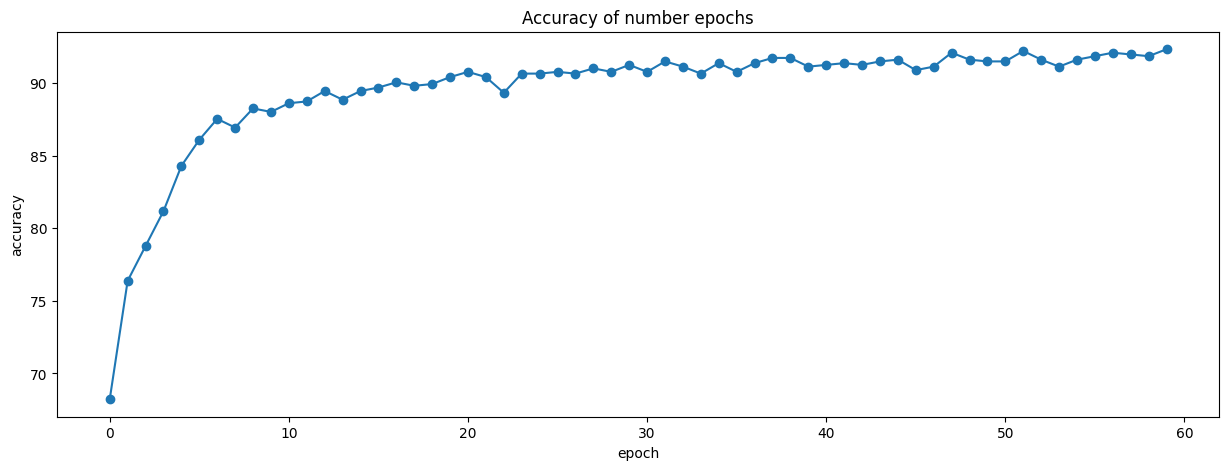

In [47]:
plot_accuracy(result)

In [48]:
def plot_losses(train_loss, val_loss):
  train_losses = [x for x in train_loss]
  val_losses = [x for x in val_loss]

  plt.figure(figsize=(15,5))
  plt.plot(train_losses, marker='x')
  plt.plot(val_losses, marker='o')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title("Plot Training and Validation Losses")

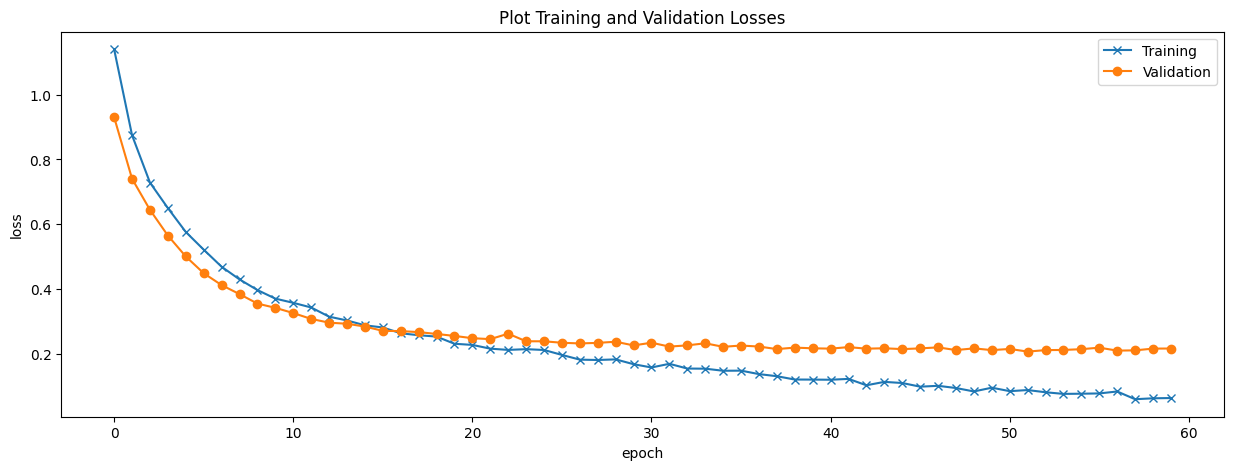

In [49]:
plot_losses(train_loss, val_loss)

### Test results of train model

In [50]:
test_dataset = ImageFolder("/content/test", transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                      [0.42045337, 0.27952126, 0.1714828],
                                      [0.28596467, 0.20711626, 0.15339227]
                          )
                          ]))

In [51]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)

  # Pick index with highest probability
  _, preds = torch.max(yb, dim=1)
  
  # Retrieve the class label
  return train_dataset.classes[preds[0].item()]

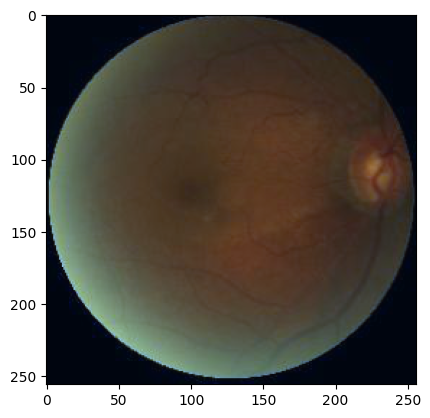

Label : glaucoma | Predicted : glaucoma


In [52]:
img, label = test_dataset[120]
# Normalized Image to show the original image
normalized_image = (img - img.min()) / (img.max() - img.min())

plt.imshow(normalized_image.permute(1, 2, 0))
plt.show()
print(f"Label : {train_dataset.classes[label]} | Predicted : {predict_image(img, model)}")

Save the model

In [53]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "ClassificationEyeDisease.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/ClassificationEyeDisease.pth
